 This will be a quick and dirty kernel showing how to get started on segmenting nuclei using a neural network in Pytorch.The architecture used is the so-called U-Net, which is very common for image segmentation problems such as this. 
<br>
<br>
    You can understand more about unet from [https://arxiv.org/abs/1505.04597]. Also implementation of same using keras is described in my [blog](http://https://medium.com/@arunm8489/an-overview-on-u-net-architecture-d6caabf7caa4) post.

In [25]:
import os
import time
import copy
from collections import defaultdict
import torch
import shutil
import pandas as pd
from skimage import io, transform
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms, utils
from torch import nn
from albumentations import (HorizontalFlip, ShiftScaleRotate, Normalize, Resize, Compose, GaussNoise)
import cv2
from albumentations.pytorch import ToTensorV2
from torch.autograd import Variable
from torch.nn import Linear, ReLU, CrossEntropyLoss, Sequential, Conv2d, MaxPool2d, Module, Softmax, BatchNorm2d, Dropout
from torch.optim import Adam, SGD
import torch.nn.functional as F
from PIL import Image
from torch import nn
import zipfile
from tqdm import tqdm, trange
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')


In [26]:
#! mkdir /kaggle/working/data
# ! unzip /kaggle/input/data-science-bowl-2018/stage1_train.zip -d /kaggle/working/data

In [27]:
if not os.path.exists('data'):
    os.mkdir('data')
    
zip_path = 'stage1_train.zip'
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall('data')

## Loading Data

Now we will load the data by using custom data loader from pytorch along with small preprocessing such as horizontal fliping and normalization.

In [28]:
def get_transforms(mean, std):
            list_transforms = []
            
            list_transforms.extend(
                    [
            HorizontalFlip(p=0.5), # only horizontal flip as of now
                    ])
            list_transforms.extend(
                    [
            Normalize(mean=mean, std=std, p=1),
            ToTensorV2(),
                    ])
            list_trfms = Compose(list_transforms)
            return list_trfms




import cv2
class Nuclie_data(Dataset):
        def __init__(self,path):
            self.path = path
            self.folders = os.listdir(path)
            self.transforms = get_transforms(0.5, 0.5)
        
        def __len__(self):
            return len(self.folders)
              
        
        def __getitem__(self,idx):
            image_folder = os.path.join(self.path,self.folders[idx],'images/')
            mask_folder = os.path.join(self.path,self.folders[idx],'masks/')
            image_path = os.path.join(image_folder,os.listdir(image_folder)[0])
            
            img = cv2.imread(image_path)[:,:,:3].astype('float32')
            b,g,r = cv2.split(img)
            img = cv2.merge([r,g,b])
            img = transform.resize(img,(128,128))
            
            mask = self.get_mask(mask_folder, 128, 128 ).astype('float32')

            augmented = self.transforms(image=img, mask=mask)
            img = augmented['image']
            mask = augmented['mask']
            mask = mask.permute(2, 0, 1)
            return (img,mask) 


        def get_mask(self,mask_folder,IMG_HEIGHT, IMG_WIDTH):
            mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool_)
            for mask_ in os.listdir(mask_folder):
                    mask_ = io.imread(os.path.join(mask_folder,mask_))
                #     b,g,r = cv2.split(mask_)
                #     mask_ = cv2.merge([r,g,b])
                    mask_ = transform.resize(mask_, (IMG_HEIGHT, IMG_WIDTH))
                    mask_ = np.expand_dims(mask_,axis=-1)
                    mask = np.maximum(mask, mask_)
              
            return mask
            


In [29]:
#loading the data
base_dir = 'data/'
data = Nuclie_data(base_dir)

In [30]:
# print out some sample data
print(data.__len__())
data.__getitem__(0)

670


(tensor([[[-0.9588, -0.9608, -0.9612,  ..., -0.9472, -0.9658, -0.9739],
          [-0.9514, -0.9602, -0.9623,  ..., -0.9449, -0.9625, -0.9719],
          [-0.9351, -0.9517, -0.9566,  ..., -0.9445, -0.9629, -0.9737],
          ...,
          [-0.9767, -0.9782, -0.9817,  ..., -0.9828, -0.9843, -0.9843],
          [-0.9780, -0.9767, -0.9767,  ..., -0.9843, -0.9843, -0.9828],
          [-0.9782, -0.9784, -0.9767,  ..., -0.9843, -0.9843, -0.9841]],
 
         [[-0.9588, -0.9608, -0.9612,  ..., -0.9472, -0.9658, -0.9739],
          [-0.9514, -0.9602, -0.9623,  ..., -0.9449, -0.9625, -0.9719],
          [-0.9351, -0.9517, -0.9566,  ..., -0.9445, -0.9629, -0.9737],
          ...,
          [-0.9767, -0.9782, -0.9817,  ..., -0.9828, -0.9843, -0.9843],
          [-0.9780, -0.9767, -0.9767,  ..., -0.9843, -0.9843, -0.9828],
          [-0.9782, -0.9784, -0.9767,  ..., -0.9843, -0.9843, -0.9841]],
 
         [[-0.9588, -0.9608, -0.9612,  ..., -0.9472, -0.9658, -0.9739],
          [-0.9514, -0.9602,

Now we will just check the shape of images and masks loaded

In [31]:
for img,msk in data:
  print(img.shape)
  print(msk.shape)
  break

torch.Size([3, 128, 128])
torch.Size([1, 128, 128])


In [32]:
# some utility functions
def mask_convert(mask):
    mask = mask.clone().cpu().detach().numpy()
    mask = mask.transpose((1,2,0))
    std = np.array((0.5))
    mean = np.array((0.5))
    mask  = std * mask + mean
    mask = mask.clip(0,1)
    mask = np.squeeze(mask)
    return mask

# converting tensor to image
def image_convert(image):
    image = image.clone().cpu().numpy()
    image = image.transpose((1,2,0))
    std = np.array((0.5,0.5,0.5))
    mean = np.array((0.5,0.5,0.5))
    image  = std * image + mean
    image = image.clip(0,1)
    image = (image * 255).astype(np.uint8)
    return image


In [33]:
def plot_img(no_):
    iter_ = iter(train_loader)
    images,masks = next(iter_)
    images = images.to(device)
    masks = masks.to(device)
    plt.figure(figsize=(10,6))
    for idx in range(0,no_):
         image = image_convert(images[idx])
         plt.subplot(2,no_,idx+1)
         plt.title('image')
         plt.imshow(image)
    for idx in range(0,no_):
         mask = mask_convert(masks[idx])
         plt.subplot(2,no_,idx+no_+1)
         plt.title('mask')
         plt.imshow(mask,cmap='gray')
    plt.show()

We will use 580 images for train and 90 images for validation

In [34]:
# splitting to trainset and validation set and loading the data with batch size of 10

trainset, valset = random_split(data, [580, 90])

train_loader = torch.utils.data.DataLoader(dataset=trainset, batch_size=64, shuffle=True,pin_memory=True)

val_loader = torch.utils.data.DataLoader(dataset=valset, batch_size=64,pin_memory=True)

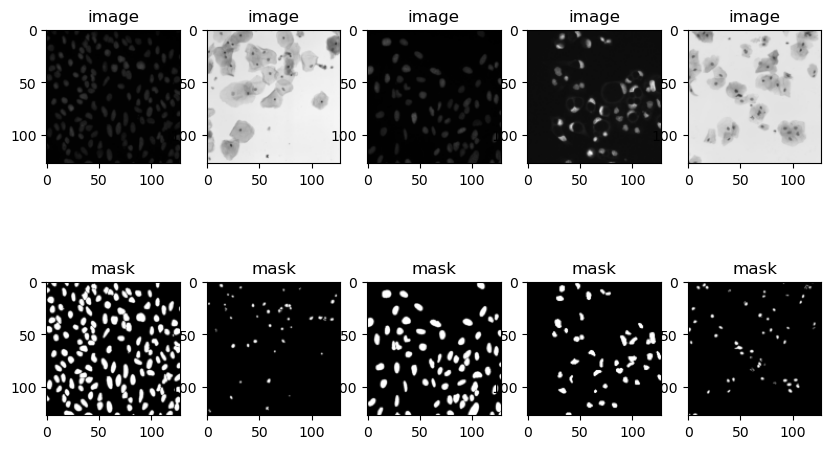

In [35]:
# we will try visualizing images and corresponding masks
plot_img(5)

In [36]:
def initialize_weights(self):
    for m in self.modules():
        if isinstance(m, nn.Conv2d):
            nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
        elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
            nn.init.constant_(m.weight, 1)
            nn.init.constant_(m.bias, 0)

In [37]:
def double_conv(in_channels, out_channels):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, 3, padding=1),
        nn.ReLU(inplace=True),
        nn.Conv2d(out_channels, out_channels, 3, padding=1),
        nn.ReLU(inplace=True)
    )

class Unet(nn.Module):
    def __init__(self):
        super().__init__()
        self.dblock1 = double_conv(3, 64)
        self.dblock2 = double_conv(64, 128)
        self.dblock3 = double_conv(128,256)
        self.dblock4 = double_conv(256,512)

        self.pool = nn.MaxPool2d(2)
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True) 

        self.dblock5 = double_conv(256 + 512, 256)
        self.dblock6 = double_conv(128 + 256, 128)
        self.dblock7 = double_conv(128 + 64, 64)

        self.last_layer = nn.Conv2d(64,1,1)
        self.sigmoid = nn.Sigmoid()

    def forward(self,x):
        conv1 = self.dblock1(x)
        x = self.pool(conv1)

        conv2 = self.dblock2(x)
        x = self.pool(conv2)

        conv3 = self.dblock3(x)
        x = self.pool(conv3)

        conv4 = self.dblock4(x)
        
        x = self.upsample(conv4)

        x = torch.cat([x, conv3], dim=1)

        x = self.dblock5(x)
        x = self.upsample(x)
        x = torch.cat([x, conv2], dim=1)
        
        x = self.dblock6(x)
        x = self.upsample(x)
        x = torch.cat([x, conv1], dim=1)
        
        x = self.dblock7(x)

        out = self.last_layer(x)
        # out = self.sigmoid(x)
        return out



In [38]:
model = Unet().to(device)
print(list(model.parameters()))
print("-------初始化-------")

initialize_weights(model)
print(list(model.parameters()))
model

[Parameter containing:
tensor([[[[ 0.0820,  0.0008, -0.1723],
          [ 0.0823, -0.0303,  0.0689],
          [ 0.0374, -0.0208, -0.1217]],

         [[-0.0025, -0.0249,  0.0104],
          [-0.0802,  0.1281,  0.0949],
          [ 0.0483,  0.1163, -0.1156]],

         [[-0.1403,  0.0459,  0.0804],
          [-0.0099, -0.1147, -0.0208],
          [ 0.1336,  0.0237, -0.1546]]],


        [[[-0.0800,  0.0078,  0.1316],
          [ 0.1744,  0.1512, -0.0910],
          [ 0.0906,  0.1664, -0.1342]],

         [[ 0.1785,  0.1860,  0.1743],
          [-0.0150,  0.0872,  0.0367],
          [-0.1036,  0.0951,  0.0219]],

         [[ 0.0175,  0.0101,  0.1861],
          [ 0.0456, -0.1476,  0.0976],
          [ 0.1554,  0.1799, -0.1209]]],


        [[[ 0.0878,  0.0549, -0.1578],
          [-0.1711,  0.0868, -0.0887],
          [ 0.1856, -0.1279,  0.1064]],

         [[ 0.0914,  0.1079, -0.1410],
          [-0.0824,  0.0235,  0.1128],
          [ 0.0589,  0.0486,  0.0830]],

         [[-0.1117, -

Unet(
  (dblock1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (dblock2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (dblock3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (dblock4): Sequential(
    (0): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (pool): MaxPool2d(kernel_size=2, stride=2,

### Loss function and IOU metric


This loss combines Dice loss with the standard binary cross-entropy (BCE) loss that is generally the default for segmentation models. Combined the two methods allows for some diversity in the loss, while benefitting from the stability of BCE.Similarly we use intersection over union as a metric

In [39]:
class DiceBCELoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceBCELoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):
        
        #comment out if your model contains a sigmoid or equivalent activation layer
        inputs = torch.sigmoid(inputs)       
        bce_weight = 0.5
        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        intersection = (inputs * targets).sum()                            
        dice_loss = 1 - (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)  
        BCE = F.binary_cross_entropy(inputs, targets, reduction='mean')
        loss_final = BCE * bce_weight + dice_loss * (1 - bce_weight)
        return loss_final
    
## IOU computation
def iou_(y_pred,y):
    inputs = y_pred.reshape(-1)
    targets = y.reshape(-1)
    intersection = (inputs * targets).sum()
    total = (inputs + targets).sum()
    union = total - intersection 
    smooth = 1e-5    
    iou = (intersection + smooth)/(union + smooth)
    return iou



def iou_batch(y_pred,y):
    '''computes mean iou for a batch of ground truth masks and predicted masks'''
    ious = []
    y_pred = torch.sigmoid(y_pred)
    y_pred = y_pred.clone().cpu().detach().numpy()
    y = y.clone().cpu().detach().numpy() 
    
    for pred, label in zip(y_pred, y):
        ious.append(iou_(pred, label))
    iou = np.nanmean(ious)
    return iou    

Now we will write some utility functions to save and load best model on training

In [40]:
#ref https://towardsdatascience.com/how-to-save-and-load-a-model-in-pytorch-with-a-complete-example-c2920e617dee

def save_ckp(state, is_best, checkpoint_path, best_model_path):
    """
    state: checkpoint we want to save
    is_best: is this the best checkpoint; min validation loss
    checkpoint_path: path to save checkpoint
    best_model_path: path to save best model
    """
    # save checkpoint data to the path given, checkpoint_path
    torch.save(state, checkpoint_path)
    # if it is a best model, min validation loss
    if is_best:
        # copy that checkpoint file to best path given, best_model_path
        shutil.copyfile(checkpoint_path, best_model_path)
        
def load_ckp(checkpoint_fpath, model, optimizer):
    """
    checkpoint_path: path to save checkpoint
    model: model that we want to load checkpoint parameters into       
    optimizer: optimizer we defined in previous training
    """
    # load check point
    checkpoint = torch.load(checkpoint_fpath)
    # initialize state_dict from checkpoint to model
    model.load_state_dict(checkpoint['state_dict'])
    # initialize optimizer from checkpoint to optimizer
    optimizer.load_state_dict(checkpoint['optimizer'])
    # initialize valid_loss_min from checkpoint to valid_loss_min
    valid_loss_min = checkpoint['valid_loss_min']
    # return model, optimizer, epoch value, min validation loss 
    return model, optimizer, checkpoint['epoch'], valid_loss_min.item()

## Model training

In [41]:
checkpoint_path = 'chkpoint_'
best_model_path = 'bestmodel.pt'
epochs = 25
criterion = DiceBCELoss()
learning_rate = 1e-4
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
valid_loss_min = 3.95275


train_loss,val_loss = [],[]
train_iou,val_iou = [],[]

for epoch in range(epochs):
    print('Epoch {}/{}'.format(epoch + 1, epochs))
    start_time = time.time()
     

    
    running_train_loss = []
    running_train_score = []
    for image,mask in tqdm(train_loader): 
            image = image.to(device,dtype=torch.float)
            mask = mask.to(device,dtype=torch.float)
            
            pred_mask = model.forward(image) # forward propogation
            loss = criterion(pred_mask,mask)
            score = iou_batch(pred_mask,mask)
            optimizer.zero_grad() # setting gradient to zero
            loss.backward()
            optimizer.step()
            running_train_loss.append(loss.item())
            running_train_score.append(score)
                              

    else:           
        running_val_loss = []
        running_val_score = []
        with torch.no_grad():
            for image,mask in tqdm(val_loader):
                    image = image.to(device,dtype=torch.float)
                    mask = mask.to(device,dtype=torch.float)                            
                    pred_mask = model.forward(image)
                    loss = criterion(pred_mask,mask)
                    score = iou_batch(pred_mask,mask)
                    running_val_loss.append(loss.item())
                    running_val_score.append(score)

                                    
    
    epoch_train_loss,epoch_train_score = np.mean(running_train_loss) ,np.mean(running_train_score)
    print('Train loss : {} iou : {}'.format(epoch_train_loss,epoch_train_score))                       
    train_loss.append(epoch_train_loss)
    train_iou.append(epoch_train_score)
    
    epoch_val_loss,epoch_val_score = np.mean(running_val_loss),np.mean(running_val_score)
    print('Validation loss : {} iou : {}'.format(epoch_val_loss,epoch_val_score))                                
    val_loss.append(epoch_val_loss)
    val_iou.append(epoch_val_score)
    
    # create checkpoint variable and add important data
    checkpoint = {
            'epoch': epoch + 1,
            'valid_loss_min': epoch_val_loss,
            'state_dict': model.state_dict(),
            'optimizer': optimizer.state_dict(),
        }
    
    # save checkpoint
    save_ckp(checkpoint, False, checkpoint_path, best_model_path)
    ## TODO: save the model if validation loss has decreased
    if epoch_val_loss <= valid_loss_min:
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(valid_loss_min,epoch_val_loss))
            # save checkpoint as best model
            save_ckp(checkpoint, True, checkpoint_path, best_model_path)
            valid_loss_min = epoch_val_loss
    
    time_elapsed = time.time() - start_time
    print('{:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
                        


Epoch 1/25


100%|██████████| 2/2 [00:33<00:00, 16.56s/it]


Train loss : 0.6846308737993241 iou : 0.10469910871892525
Validation loss : 0.4777752757072449 iou : 0.17532105325290345
Validation loss decreased (3.952750 --> 0.477775).  Saving model ...
4m 51s
Epoch 2/25


100%|██████████| 2/2 [00:22<00:00, 11.05s/it]


Train loss : 0.4280413776636124 iou : 0.23020412085494457
Validation loss : 0.44741518795490265 iou : 0.23140407957155507
Validation loss decreased (0.477775 --> 0.447415).  Saving model ...
3m 31s
Epoch 3/25


100%|██████████| 2/2 [00:22<00:00, 11.07s/it]


Train loss : 0.368895497918129 iou : 0.3080581904752677
Validation loss : 0.3681362718343735 iou : 0.3399068216522003
Validation loss decreased (0.447415 --> 0.368136).  Saving model ...
3m 29s
Epoch 4/25


100%|██████████| 2/2 [00:22<00:00, 11.04s/it]


Train loss : 0.3098123729228973 iou : 0.39085564781830306
Validation loss : 0.5032402276992798 iou : 0.2977936209455013
3m 29s
Epoch 5/25


100%|██████████| 2/2 [00:22<00:00, 11.42s/it]


Train loss : 0.3931802362203598 iou : 0.3561823996859328
Validation loss : 0.34349918365478516 iou : 0.3734731715137666
Validation loss decreased (0.368136 --> 0.343499).  Saving model ...
3m 35s
Epoch 6/25


100%|██████████| 2/2 [00:21<00:00, 10.87s/it]


Train loss : 0.29088655710220335 iou : 0.4092586854676781
Validation loss : 0.2662579119205475 iou : 0.45014828008690977
Validation loss decreased (0.343499 --> 0.266258).  Saving model ...
3m 28s
Epoch 7/25


100%|██████████| 2/2 [00:21<00:00, 10.99s/it]


Train loss : 0.24110299199819565 iou : 0.47015362633978536
Validation loss : 0.22832299023866653 iou : 0.4964121591764239
Validation loss decreased (0.266258 --> 0.228323).  Saving model ...
3m 26s
Epoch 8/25


100%|██████████| 2/2 [00:21<00:00, 10.98s/it]


Train loss : 0.22839773148298265 iou : 0.49464891139004374
Validation loss : 0.20916032791137695 iou : 0.5478559467148254
Validation loss decreased (0.228323 --> 0.209160).  Saving model ...
3m 26s
Epoch 9/25


100%|██████████| 2/2 [00:21<00:00, 10.81s/it]


Train loss : 0.20337297022342682 iou : 0.531592896078427
Validation loss : 0.22260898351669312 iou : 0.5631612625797531
3m 26s
Epoch 10/25


100%|██████████| 2/2 [00:21<00:00, 10.90s/it]


Train loss : 0.20611608624458314 iou : 0.5434146250287095
Validation loss : 0.22497854381799698 iou : 0.5691207786674699
3m 26s
Epoch 11/25


100%|██████████| 2/2 [00:21<00:00, 10.99s/it]


Train loss : 0.21084724068641664 iou : 0.5479661448258801
Validation loss : 0.23755449056625366 iou : 0.5640905770095137
3m 26s
Epoch 12/25


100%|██████████| 2/2 [00:21<00:00, 10.91s/it]


Train loss : 0.2141455367207527 iou : 0.5649701143884381
Validation loss : 0.18359854817390442 iou : 0.5777382198650602
Validation loss decreased (0.209160 --> 0.183599).  Saving model ...
3m 26s
Epoch 13/25


100%|██████████| 2/2 [00:21<00:00, 10.85s/it]


Train loss : 0.18591693937778472 iou : 0.5613474489434808
Validation loss : 0.18917673081159592 iou : 0.6153528864616735
3m 26s
Epoch 14/25


100%|██████████| 2/2 [00:21<00:00, 11.00s/it]


Train loss : 0.18573531359434128 iou : 0.5940898257963084
Validation loss : 0.16553408652544022 iou : 0.629344024967804
Validation loss decreased (0.183599 --> 0.165534).  Saving model ...
3m 27s
Epoch 15/25


100%|██████████| 2/2 [00:21<00:00, 10.82s/it]


Train loss : 0.168363618850708 iou : 0.6012225599868101
Validation loss : 0.1553802266716957 iou : 0.6294516323275188
Validation loss decreased (0.165534 --> 0.155380).  Saving model ...
3m 26s
Epoch 16/25


100%|██████████| 2/2 [00:21<00:00, 10.78s/it]


Train loss : 0.15895164310932158 iou : 0.6363183515669557
Validation loss : 0.14967263489961624 iou : 0.6417654676660869
Validation loss decreased (0.155380 --> 0.149673).  Saving model ...
3m 25s
Epoch 17/25


100%|██████████| 2/2 [00:21<00:00, 10.87s/it]


Train loss : 0.15726823657751082 iou : 0.6394056567444191
Validation loss : 0.20243455469608307 iou : 0.5682633065786862
3m 26s
Epoch 18/25


100%|██████████| 2/2 [00:21<00:00, 10.89s/it]


Train loss : 0.16440340131521225 iou : 0.6209585068986634
Validation loss : 0.1826665699481964 iou : 0.639605761599382
3m 27s
Epoch 19/25


100%|██████████| 2/2 [00:21<00:00, 10.79s/it]


Train loss : 0.15576085597276687 iou : 0.645329265957377
Validation loss : 0.1385316327214241 iou : 0.6628681496145933
Validation loss decreased (0.149673 --> 0.138532).  Saving model ...
3m 26s
Epoch 20/25


100%|██████████| 2/2 [00:21<00:00, 10.83s/it]


Train loss : 0.1426107630133629 iou : 0.649970324816426
Validation loss : 0.13338957726955414 iou : 0.6961715264447839
Validation loss decreased (0.138532 --> 0.133390).  Saving model ...
3m 26s
Epoch 21/25


100%|██████████| 2/2 [00:21<00:00, 10.86s/it]


Train loss : 0.141471329331398 iou : 0.6733490716735453
Validation loss : 0.13422660529613495 iou : 0.6893907692917844
3m 26s
Epoch 22/25


100%|██████████| 2/2 [00:21<00:00, 10.82s/it]


Train loss : 0.15535895749926568 iou : 0.6685207227758807
Validation loss : 0.13810168951749802 iou : 0.6969267634857224
3m 26s
Epoch 23/25


100%|██████████| 2/2 [00:21<00:00, 10.98s/it]


Train loss : 0.14455720633268357 iou : 0.6661180659438506
Validation loss : 0.1336572989821434 iou : 0.6881138053698692
3m 26s
Epoch 24/25


100%|██████████| 2/2 [00:21<00:00, 10.86s/it]


Train loss : 0.1300528608262539 iou : 0.681777750737228
Validation loss : 0.13430889695882797 iou : 0.7087168937976747
3m 26s
Epoch 25/25


100%|██████████| 2/2 [00:21<00:00, 10.83s/it]


Train loss : 0.12535409405827522 iou : 0.6993421061135553
Validation loss : 0.12221935391426086 iou : 0.7160761257317074
Validation loss decreased (0.133390 --> 0.122219).  Saving model ...
3m 26s


## Plotting Loss and IOU Scores

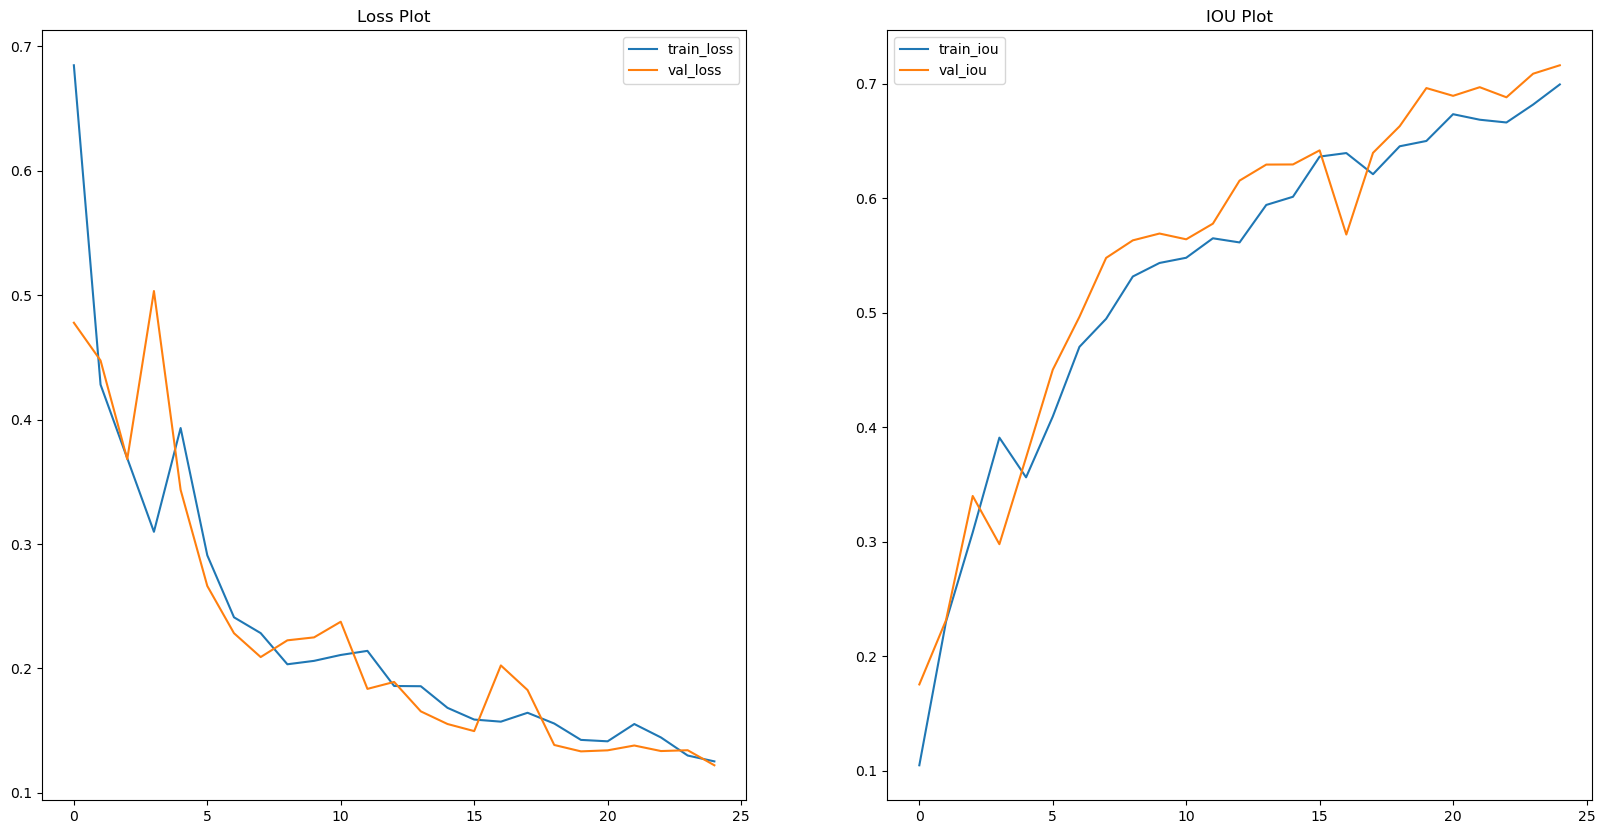

In [42]:
plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
plt.plot(train_loss,label='train_loss')
plt.plot(val_loss,label='val_loss')
plt.legend()
plt.title('Loss Plot')
plt.subplot(1,2,2)
plt.plot(train_iou,label='train_iou')
plt.plot(val_iou,label='val_iou')
plt.legend()
plt.title('IOU Plot')
plt.show()

In [43]:
#loading the saved model
model, optimizer, start_epoch, valid_loss_min = load_ckp(checkpoint_path, model, optimizer)

## Visualisation of actual and predicted mask

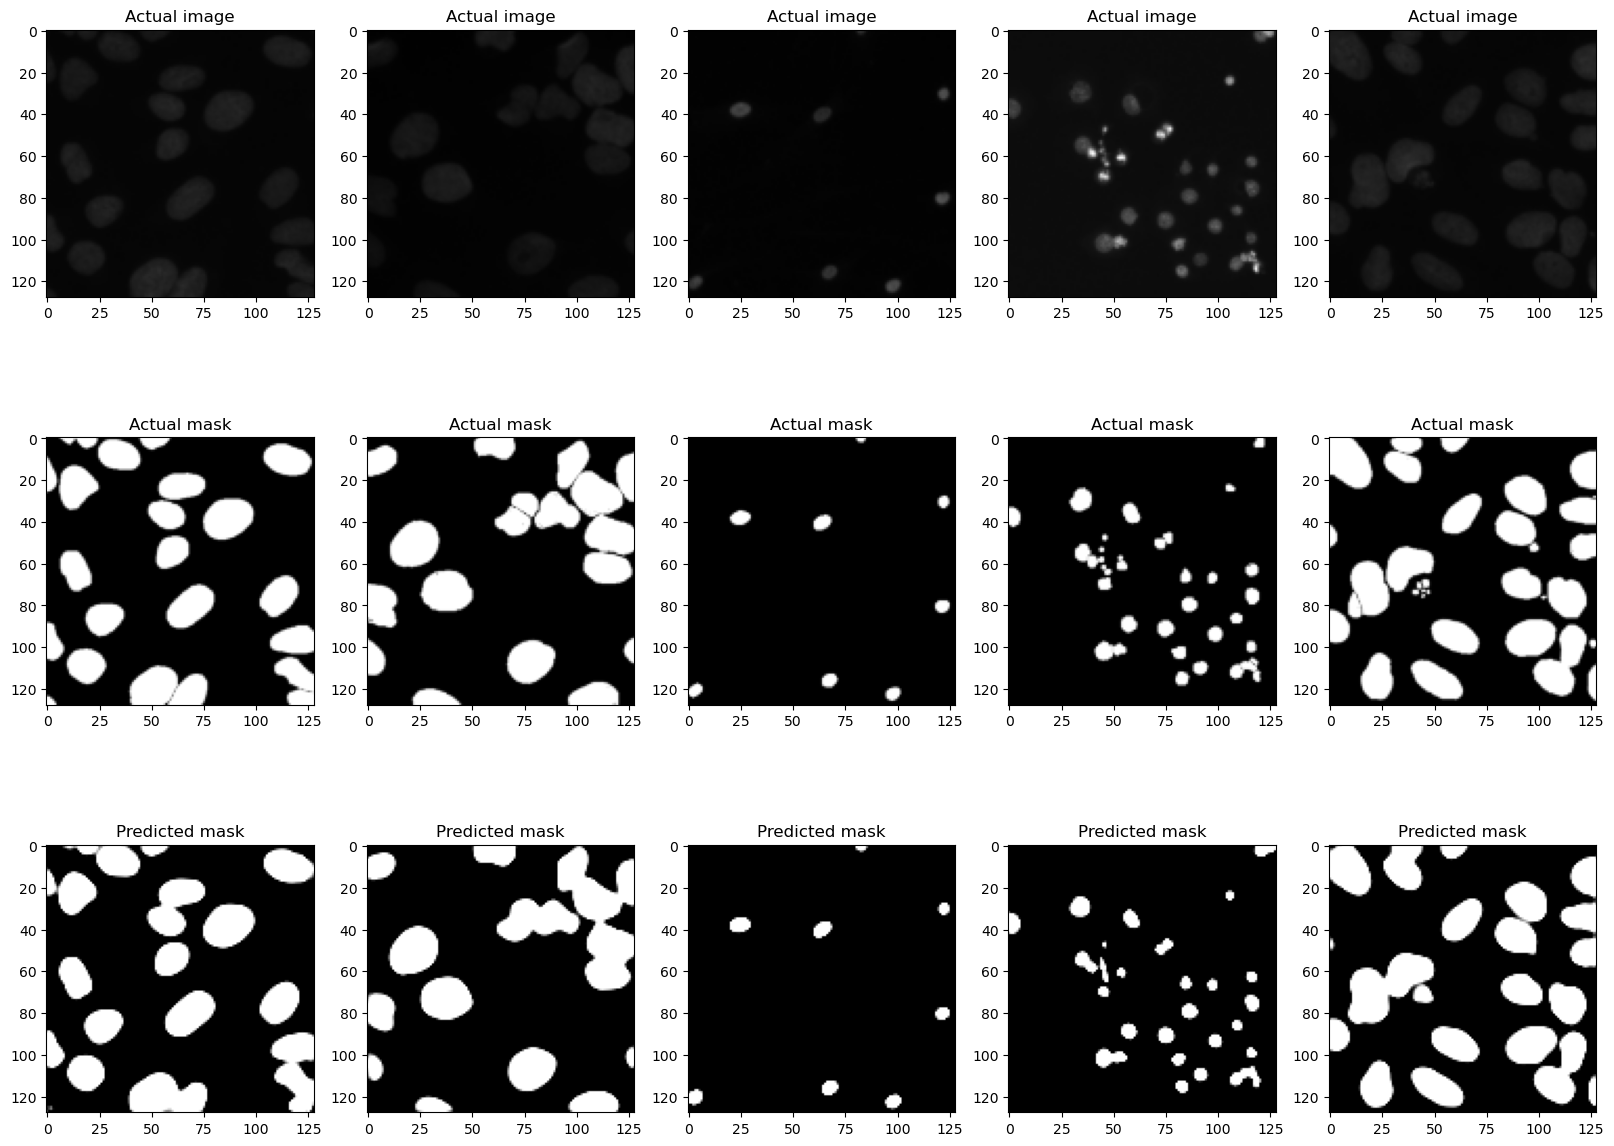

In [44]:

iter_ = iter(val_loader)
image,mask = next(iter_)
image = image.to(device,dtype=torch.float)
mask = mask.to(device,dtype=torch.float)
y_pred = model.forward(image)


plt.figure(figsize=(20,15))
for i in range(0,5):
    plt.subplot(3,5,i+1)
    plt.title('Actual image')
    plt.imshow(image_convert(image[i]))
for i in range(0,5):
    plt.subplot(3,5,i+5+1)
    plt.title('Actual mask')
    plt.imshow(mask_convert(mask[i]),cmap='gray')
for i in range(0,5):
    plt.subplot(3,5,i+10+1)
    plt.title('Predicted mask')
    plt.imshow(mask_convert(y_pred[i]),cmap='gray')
plt.show()
    
    